# 問題挖掘

目標在於從資料觀察公司有什麼潛在的問題，主要會完成：
* 抽樣資料敘述統計 
* 抽樣資料RFM分析 
* 顧客活躍度及ARFM分析


* [載入/預覽資料](#載入/預覽資料)
    * [交易記錄檔](#交易記錄檔)
    * [顧客資料檔](#顧客資料檔)
    * [產品資料檔](#產品資料檔)
* [RFM 資料製作](#RFM-資料製作)
* [RFM 資料分析與視覺化](#RFM-資料分析與視覺化)
    * [RFM 資料初探](#RFM-資料初探)
    * [零元項目清理](#零元項目清理)
    * [【分析】視覺化及分析處理後資料](#【分析】視覺化及分析處理後資料)
    * [RFM 五等均分法](#RFM-五等均分法)
* [顧客活躍性分析](#顧客活躍性分析)
    * [計算購買期間](#計算購買期間)
    * [計算活躍度指標](#計算活躍度指標)
    * [【分析】活躍度指標分析](#【分析】活躍度指標分析)
    * [【分析】ARFM 分析](#【分析】ARFM-分析)
    * [【分析】流失客戶分析](#【分析】流失客戶分析)
* [儲存處理後資料](#儲存處理後資料)

<div id="toc"></div>

In [1]:
# %%javascript
# $.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
# 在 jupyter notebook 裡面加入這段和上面的html可以自動產生目錄，但這邊我自己輸入

<IPython.core.display.Javascript object>

-----

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK TC']  # 為 matplotlib設定中文字型，作圖時才能正確顯示中文

## 載入/預覽資料

In [3]:
transactions = pd.read_csv("交易記錄檔.csv", encoding="big5")
customers = pd.read_csv("客戶資料檔.csv")
products = pd.read_csv("產品資料檔.csv")

### 交易記錄檔
* 資料期間：2006/01/01 - 2007/12/31
* 資料筆數：3077
* 欄位：交易編號、Date、ID、Product_ID、Quantity、Amount

In [4]:
# 觀察資料表結構 #
transactions.head()

,交易編號,Date,ID,Product_ID,Quantity,Amount
0,86,20060101,92,2842,1,45
1,124,20060102,198,67438,1,599
2,273,20060104,338,68431,1,1990
3,273,20060104,338,68431,1,2499
4,273,20060104,338,68431,3,7497


In [5]:
# 敘述統計 #
transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
交易編號,3077.0,4.036755e+04,24609.905085,86.0,17050.0,40308.0,62338.0,82189.0
Date,3077.0,2.006643e+07,4978.427557,20060101.0,20060729.0,20070228.0,20070811.0,20071231.0
ID,3077.0,2.690822e+03,2156.730740,62.0,921.0,2030.0,3873.0,8202.0
Product_ID,3077.0,6.163962e+04,19866.888393,2760.0,55539.0,69165.0,73975.0,85408.0
Quantity,3077.0,1.153721e+00,0.907685,1.0,1.0,1.0,1.0,21.0
Amount,3077.0,1.575798e+03,4400.605411,0.0,129.0,399.0,999.0,69500.0


### 顧客資料檔
* 顧客數:200 人，其中包含男性 120 人，女性 80 人
* 地區：北區、中區、南區、東區、外島地區，北區人數最多
* 平均年齡: 42歲 (中位數: 40歲)
    * 有些人的年齡資料(E.g. 1歲、108歲)很奇怪，但這邊因為幾乎沒有操作到年齡資料，所以先暫時不去清理這個欄位
* 樣本可信度高，因為整體分布跟加入控制變數下的分布類似

In [6]:
# 觀察資料表結構 #
customers.head()

,客戶ID,Gender,Age,Zipcode,Area
0,3596,男,37,247,北區
1,1729,女,29,112,北區
2,2036,男,30,237,北區
3,1686,男,34,234,北區
4,5943,女,48,802,南區


In [7]:
# 敘述統計 #
customers.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
客戶ID,200,NaN,NaN,NaN,4112.91,2400.55,62,2100.5,3870.5,6147.75,8202
Gender,200,2,男,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,200,NaN,NaN,NaN,42.55,13.3167,1,34,40,50,108
Zipcode,200,NaN,NaN,NaN,419.18,246.605,103,236.75,330,619.25,973
Area,200,5,北區,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN


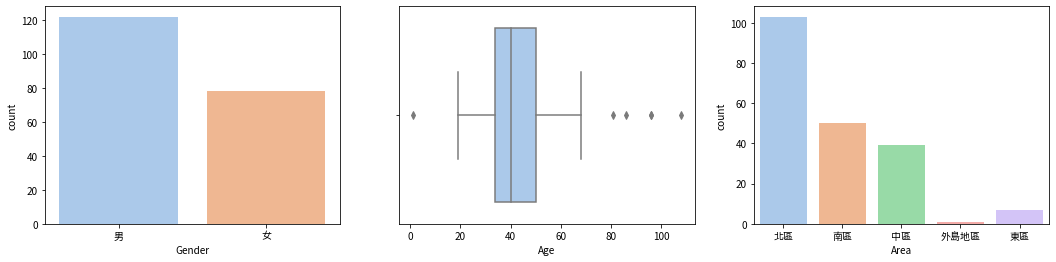

In [8]:
# 畫圖觀察性別、年齡、地區的整體分布 #
fig, ax= plt.subplots(1, 3, figsize=(18, 4))
sns.countplot(ax=ax[0], x="Gender", palette="pastel", data=customers)
sns.boxplot(ax=ax[1], x="Age",  palette="pastel", data=customers)
sns.countplot(ax=ax[2], x='Area',  palette="pastel", data=customers)
plt.show()

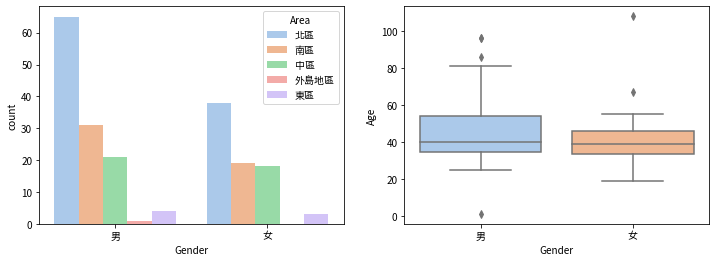

In [9]:
# 作圖觀察變數間的關係：以性別為自變數 #
fit,ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(ax=ax[0], x="Gender", hue="Area", palette="pastel", data=customers)
sns.boxplot(ax=ax[1], x="Gender", y="Age", palette="pastel", data=customers)
plt.show()

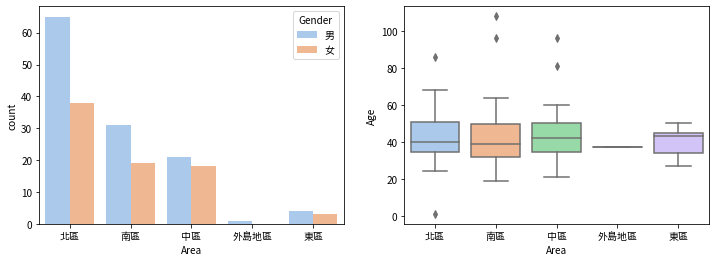

In [10]:
# 作圖觀察變數間的關係：以地區為自變數 #
fit,ax = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(ax=ax[0], x="Area", hue="Gender", palette="pastel", data=customers)
sns.boxplot(ax=ax[1], x="Area", y="Age", palette="pastel", data=customers)
plt.show()

### 產品資料檔
* 產品項目數量：1130
* 產品種類：30
* 售出數量前三名產品：DVD燒錄片、有線光學鼠、CD燒錄片
* 抽樣期間多數的產品都未更動過定價，僅有134項產品調整價格，多數為耗材與服務收費。
    * 相較於所有產品平均價格2449元，此類產品價格不高，大約1000元以內可購得。

In [11]:
# 觀察資料表結構 #
products.head()

,Product_ID,Product,Category_ID,Category
0,2760,國際黑1號池,40301,一般電池
1,2761,國際黑2號池,40301,一般電池
2,2762,國際黑3號池,40301,一般電池
3,2766,勁量鹼性電池1號2入,40302,鹼性電池
4,2772,勁量鹼性電池9V1入,40302,鹼性電池


In [12]:
# 敘述統計 #
products.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Product_ID,1130,NaN,NaN,NaN,66386.4,17467.6,2760,64283.2,71339.5,77016.8,85408
Product,1130,1053,華碩筆記型電腦,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category_ID,1130,NaN,NaN,NaN,4.13998e+06,1.71815e+06,10809,4.1001e+06,5.0901e+06,5.1701e+06,7.0002e+06
Category,1130,30,DVD燒錄片,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# 加入商品平均價格(AvgAmount) 和 商品價格調整次數(NPrice)後，觀察敘述統計 #
products_avg_amount = transactions.groupby('Product_ID', as_index=False)['Amount'].mean()
products_n_price = transactions.groupby('Product_ID', as_index=False)['Amount'].apply(lambda x: len(x.unique()))
products = products.merge(products_avg_amount, on='Product_ID')
products = products.merge(products_n_price, on='Product_ID')
products = products.rename(columns={'Amount_x': 'AvgAmount', 'Amount_y': 'NPrice'})
                                                                                      
products.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Product_ID,1130,NaN,NaN,NaN,66386.4,17467.6,2760,64283.2,71339.5,77016.8,85408
Product,1130,1053,華碩筆記型電腦,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category_ID,1130,NaN,NaN,NaN,4.13998e+06,1.71815e+06,10809,4.1001e+06,5.0901e+06,5.1701e+06,7.0002e+06
Category,1130,30,DVD燒錄片,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AvgAmount,1130,NaN,NaN,NaN,2448.84,6113.54,0,199,399,1386.14,69500
NPrice,1130,NaN,NaN,NaN,1.56549,1.29578,1,1,1,2,14


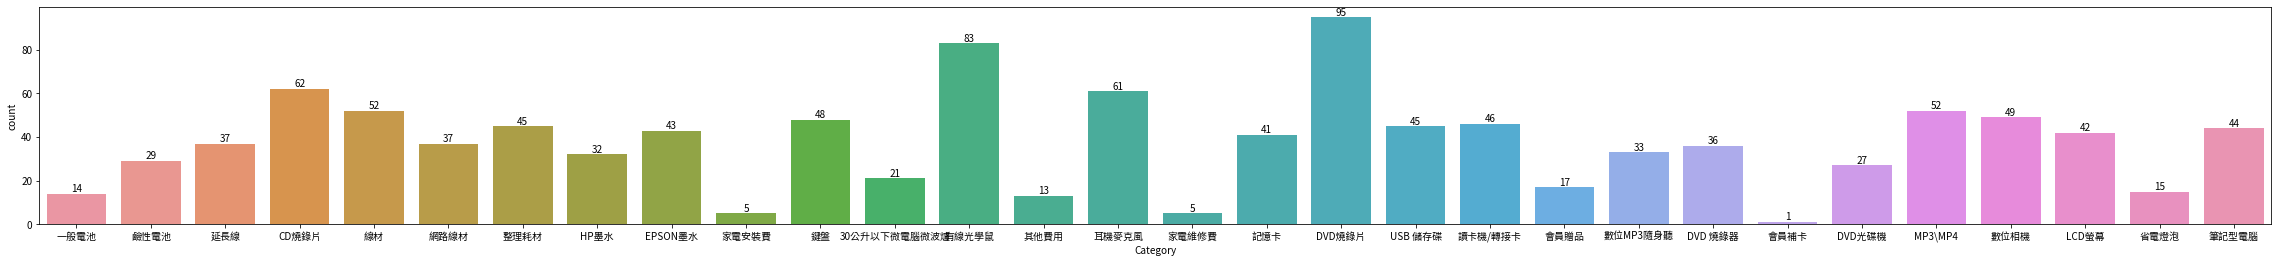

In [14]:
# 作圖觀察各商品種類銷售數量 #
fig, ax = plt.subplots(1,1, figsize=(40, 4))
sns.countplot(ax=ax, x='Category', data=products)
for p in ax.patches:
    value = p.get_height()
    if value > 0:
        ax.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')
plt.show()

In [15]:
# 顯示調整價格的商品種類 #
pd.set_option('display.max_rows', None)
products[products.NPrice>2]

,Product_ID,Product,Category_ID,Category,AvgAmount,NPrice
0,2760,國際黑1號池,40301,一般電池,57.857143,3
2,2762,國際黑3號池,40301,一般電池,55.250000,3
10,2808,國際鹼性電池3號(量販包),40302,鹼性電池,108.400000,9
11,2809,國際鹼性電池4號(量販包),40302,鹼性電池,121.235294,10
27,2867,國際牌碳鋅3號電池12粒裝,40301,一般電池,84.000000,3
45,16778,群加 CAT5E 網路線-1M,5100201,網路線材,68.375000,4
47,16780,群加 CAT5E 網路線-3M,5100201,網路線材,132.000000,4
48,16781,群加 CAT5E 網路線-5M,5100201,網路線材,174.750000,3
51,16784,群加 CAT5E 網路線-20M,5100201,網路線材,424.250000,3
59,16959,HP 49號彩色墨匣,5110201,HP墨水,1015.250000,4


In [16]:
pd.options.display.max_rows = 60 # 重新設定顯示列數

## RFM 資料製作
首先將日期資料由字串轉換為Timestamp型態，並加入以下欄位
* FirstPurchase: 資料期間首次購買日期
* NPurchase: 購買紀錄數量
* Reccency: 基準日與最後一次購買相差天數
* Frequency: 購買次數
* MonetaryValue: 平均購買金額
* TotalAmount: 總購買金額

In [17]:
split_date = lambda x: str(x)[0:4] + '/' + str(x)[4:6] + '/' + str(x)[6:]   # 調整日期格式成 "YYYY/MM/DD" 的字串
transactions.Date = pd.to_datetime(transactions['Date'].apply(split_date))  # 利用 pd.to_datetime()轉成日期格式

In [18]:
transactions.head()

,交易編號,Date,ID,Product_ID,Quantity,Amount
0,86,2006-01-01,92,2842,1,45
1,124,2006-01-02,198,67438,1,599
2,273,2006-01-04,338,68431,1,1990
3,273,2006-01-04,338,68431,1,2499
4,273,2006-01-04,338,68431,3,7497


In [19]:
# 設定 Rececncy 計算基準日 #
benchmark_date = pd.Timestamp("2008/1/1")

In [20]:
# 建立首次購買日期、購買次數、距今消費天數(Recency)、購買頻率(Frequency)、平均消費金額(Monetary Value)、總消費金額的資料 #
first_purchase_date = transactions.groupby('ID', as_index=False)['Date'].min()
first_purchase_date.columns = ['ID', 'FirstPurchase']

n_purchase_record = transactions.groupby('ID', as_index=False)['Quantity'].count()
n_purchase_record.columns = ['ID', 'NPurchase']

reccency = transactions.groupby('ID', as_index=False)['Date'].max()
reccency.columns = ['ID', 'Reccency']
reccency['Reccency'] = (benchmark_date - reccency['Reccency']).apply(lambda x: x.days)

frequency = transactions.groupby('ID', as_index=False)['Date'].apply(lambda x: len(x.unique()))
frequency.columns = ['ID', 'Frequency']

monetary_value = transactions.groupby('ID', as_index=False)['Amount'].mean()
monetary_value.columns = ['ID', 'MonetaryValue']

total_amount = transactions.groupby('ID', as_index=False)['Amount'].sum()
total_amount.columns = ['ID', 'TotalAmount']

In [21]:
# 將以上資料併入原本客戶資料，命名為 rfm_data #
rfm_data = customers.merge(first_purchase_date, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(n_purchase_record, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(reccency, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(frequency, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(monetary_value, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(total_amount, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID')

In [22]:
# 瀏覽 rfm_data #
rfm_data.sort_values(by='客戶ID')

,客戶ID,Gender,Age,Zipcode,Area,FirstPurchase,NPurchase,Reccency,Frequency,MonetaryValue,TotalAmount
136,62,女,35,235,北區,2006-01-05,18,8,14,464.222222,8356
153,87,女,55,106,北區,2006-02-13,16,43,11,1827.187500,29235
176,92,男,58,224,北區,2006-01-01,18,44,10,2791.777778,50252
155,139,男,57,114,北區,2006-02-02,19,44,15,929.157895,17654
154,198,男,27,832,南區,2006-01-02,27,112,19,676.925926,18277
...,...,...,...,...,...,...,...,...,...,...,...
106,8006,女,51,423,中區,2007-11-18,3,44,1,133.333333,400
53,8059,男,50,429,中區,2007-11-20,3,42,1,880.333333,2641
142,8141,女,38,702,南區,2007-12-21,4,10,2,225.000000,900
121,8192,女,38,407,中區,2007-12-28,5,4,1,666.400000,3332


## RFM 資料分析與視覺化

###  RFM 資料初探
* Reccency, Frequency 和 TotalAmount 受離群值影響嚴重，宜觀察中位數作為平均水準
* 由 Frequency 推得平均購買間隔天數為 720 天/ 6 次 = 120 天/次 > 46 = Reccency 中位數
    * 購買發生接近基準日，整體顧客購買「可能」有成長趨勢
* **資料內有 0 元項目，必須檢查資料**

In [23]:
# 觀察 RFM 資料 #
rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
客戶ID,200.0,4112.910000,2400.550205,62.0,2100.500000,3870.500000,6147.750000,8202.0
Age,200.0,42.550000,13.316688,1.0,34.000000,40.000000,50.000000,108.0
Zipcode,200.0,419.180000,246.604739,103.0,236.750000,330.000000,619.250000,973.0
NPurchase,200.0,15.385000,20.293247,1.0,5.000000,9.000000,18.000000,172.0
Reccency,200.0,85.960000,87.324028,1.0,23.000000,46.000000,150.000000,514.0
Frequency,200.0,9.075000,11.183682,1.0,2.750000,6.000000,11.250000,78.0
MonetaryValue,200.0,1343.227869,1284.478468,0.0,530.227273,1052.433333,1708.765625,7038.0
TotalAmount,200.0,24243.645000,52622.150474,0.0,3425.500000,10438.000000,26139.750000,494330.0


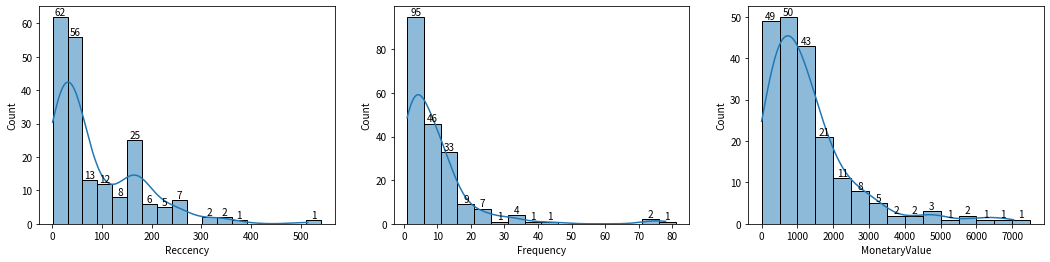

In [24]:
# 作圖觀察 RFM 分布 #
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(131)
sns.histplot(ax=ax1, data=rfm_data, x='Reccency', binwidth=30, kde=True)
for p in ax1.patches:
    value = p.get_height()
    if value > 0:
        ax1.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom') # 加入資料標籤

ax2 = fig.add_subplot(132)
sns.histplot(ax=ax2, data=rfm_data, x='Frequency', binwidth=5, kde=True)
for p in ax2.patches:
    value = p.get_height()
    if value > 0:
        ax2.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')


ax3=fig.add_subplot(133)
sns.histplot(ax=ax3, data=rfm_data, x='MonetaryValue', binwidth=500, kde=True)
for p in ax3.patches:
    value = p.get_height()
    if value > 0:
        ax3.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')


plt.show()

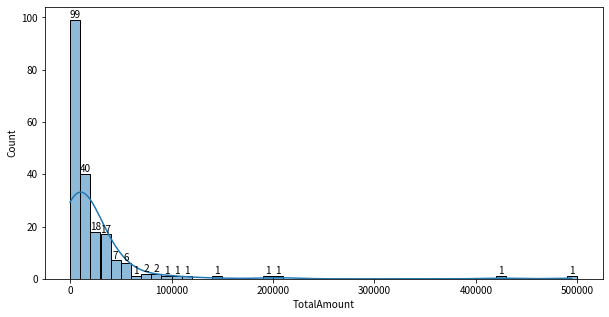

In [25]:
# 作圖觀察總金額分布 #
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.histplot(ax=ax, data=rfm_data, x='TotalAmount', binwidth=10000, kde=True)
for p in ax.patches:
    value = p.get_height()
    if value > 0:
        ax.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')
plt.show()

### 零元項目清理
* 發現大部分 0 元項目為免費維修及抵用券，不應視為購買，採取以下方式處理:
    * 抵用券(48862, 48863)、折價券(82283)：從當日消費金額扣除
    * 贈品、保修服務等：不做購買處理
* 把消費平均金額以天作為單位計算，調整以下欄位:
    * MonetaryValue
    * TotalAmount

In [26]:
# 製作 0 元商品項目資料表，方便檢視相關資訊 #
zero_item_id = transactions[transactions.Amount==0]['Product_ID'].unique()
zero_item = products[products.Product_ID.isin(zero_item_id)]

zero_item_count = transactions[transactions.Amount==0].groupby('Product_ID', as_index=False)['Quantity'].count()
zero_item_count.columns = ['Product_ID', "Count"]

zero_item = zero_item.merge(zero_item_count, on='Product_ID')
zero_item

,Product_ID,Product,Category_ID,Category,AvgAmount,NPrice,Count
0,48862,抵用券50元,6010403,其他費用,0.000000,1,9
1,48863,抵用券 100元,6010403,其他費用,0.000000,1,30
2,63042,CARD(贈品),7000200,會員補卡,7.027027,3,103
3,69542,小家電提貨券700元(贈品),6010403,其他費用,0.000000,1,12
4,69583,提貨券500元(贈品),6010403,其他費用,0.000000,1,4
5,70412,加值保修服務,6010402,家電維修費,0.000000,1,1
6,70413,免費保修服務,6010402,家電維修費,0.000000,1,71
7,71245,花茶壺,7000101,會員贈品,0.000000,1,2
8,77692,小家電商品提貨券2000元(贈品),6010403,其他費用,0.000000,1,4
9,77711,小家電商品提貨券200元(贈品),6010403,其他費用,0.000000,1,2


In [27]:
# 清理 0 元資料 #
coupons = [48862, 48863, 82283]
gift_and_service = zero_item_id[[i not in coupons for i in zero_item_id]]
transactions_cleaned = transactions[~transactions.Product_ID.isin(gift_and_service)]
transactions_cleaned[['Product_ID', 'Amount']].apply(axis=1, func=lambda x: -x[1] if x[0] in coupons else x[1])

transactions_cleaned.shape # 行數減少,因為有部分項目被拿掉

(2867, 6)

In [28]:
# 重新計算 MonetaryValue 和 TotalAmount
monetary_value = transactions_cleaned.groupby(['ID', 'Date'], as_index=False)['Amount'].sum() \
                                     .groupby('ID', as_index=False).mean()
monetary_value.columns = ['ID', 'MonetaryValue']

total_amount = transactions_cleaned.groupby('ID', as_index=False)['Amount'].sum()
total_amount.columns = ['ID', 'TotalAmount']

In [29]:
# 重新製作 rfm_data
rfm_data = customers.merge(first_purchase_date, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(n_purchase_record, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(reccency, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(frequency, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(monetary_value, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID') \
                    .merge(total_amount, left_on='客戶ID', right_on='ID') \
                    .drop(columns='ID')

### 【分析】視覺化及分析處理後資料
* 處理後： 2 個客戶因為沒有實際消費行為而被排除
* 大抵資料與原本資料差不多

**以下為 RFM 三維度觀察結果**
* Reccency:
    * 超過一半的客戶在 2 個月內有消費過
    * 6 個月內沒有消費是一個小高峰 <- 也許是流失前兆
* Frequency:
    * 接近一半的客戶在這二年內消費 0-5 次
    * 1/4 的客戶消費 6-10 次
* Monetary Value (和 Total Amount):
    * 約 3/4 的客戶平均消費金額 3000 以內
    * 約 1/2 的客戶二年消費10000元
    * 60000元以上的客戶呈零星分布

In [30]:
rfm_data.describe().T

,count,mean,std,min,25%,50%,75%,max
客戶ID,198.0,4084.823232,2396.018456,62.0,2057.500000,3861.500000,6062.000000,8202.0
Age,198.0,42.580808,13.359194,1.0,34.000000,40.000000,50.000000,108.0
Zipcode,198.0,418.696970,247.443454,103.0,236.250000,330.000000,631.750000,973.0
NPurchase,198.0,15.530303,20.343911,2.0,5.000000,9.500000,18.000000,172.0
Reccency,198.0,84.606061,86.606856,1.0,23.000000,45.500000,149.000000,514.0
Frequency,198.0,9.156566,11.210525,1.0,3.000000,6.000000,11.750000,78.0
MonetaryValue,198.0,2422.132123,2279.190698,87.0,949.049342,1714.321429,3069.666667,14754.5
TotalAmount,198.0,24484.590909,52830.020545,174.0,3497.750000,10832.500000,26419.250000,494330.0


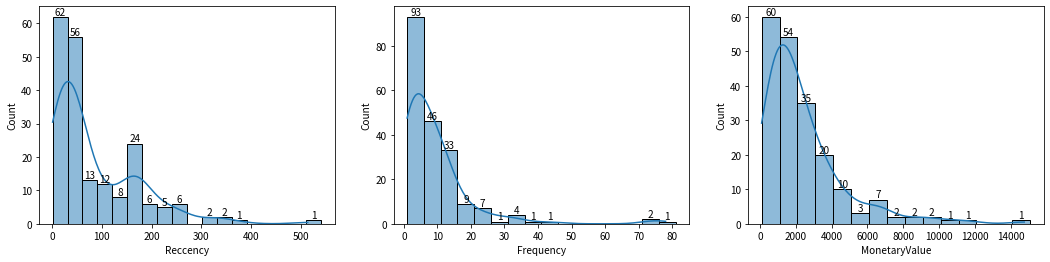

In [31]:
# 作圖觀察調整後 RFM 分布 #
fig = plt.figure(figsize=(18, 4))
ax1 = fig.add_subplot(131)
sns.histplot(ax=ax1, data=rfm_data, x='Reccency', binwidth=30, kde=True)
for p in ax1.patches:
    value = p.get_height()
    if value > 0:
        ax1.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')

ax2 = fig.add_subplot(132)
sns.histplot(ax=ax2, data=rfm_data, x='Frequency', binwidth=5, kde=True)
for p in ax2.patches:
    value = p.get_height()
    if value > 0:
        ax2.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')


ax3=fig.add_subplot(133)
sns.histplot(ax=ax3, data=rfm_data, x='MonetaryValue', binwidth=1000, kde=True)
for p in ax3.patches:
    value = p.get_height()
    if value > 0:
        ax3.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')


plt.show()

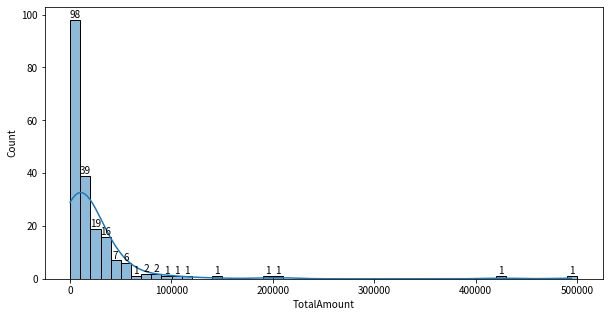

In [32]:
# 作圖觀察調整後購買總金額分布 #
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
sns.histplot(ax=ax, data=rfm_data, x='TotalAmount', binwidth=10000, kde=True)
for p in ax.patches:
    value = p.get_height()
    if value > 0:
        ax.text(x=p.get_x() + p.get_width()/2., y=value, s=value, ha='center', va='bottom')
plt.show()

### RFM 五等均分法

一般來說，取得 RFM 資料後會將每個維度分成5等分，並打上1-5的分數，最後將 RFM 三個分數相加(成為介於3-15的數值)，以分數高的來決定 VIP 顧客。但問題是，R、F、M 是 ordinal data，相加沒有意義。另外一個問題是，資料中可能相同的數值很多，使得例如說前 20% 和前 40%的數值沒有差別，這時候給予不同的分數就不合理。

RFM 均分分數本質上是一種heuristic的市場區隔方法，但缺陷很多，故不多做分析。

In [33]:
# 製作五等均分分數 #
def get_quintile_score(x, column):
    prec = np.percentile(column, [20, 40, 60, 80])
    for i in range(len(prec)):
        if x < prec[i]:
            return i + 1
    return len(prec) + 1

# 這邊注意：Recency 是越短越好，所以分數要反向排序後才計算等分分數
rfm_data['Quintile-R'] = rfm_data.Reccency.apply(func=lambda x: get_quintile_score(-x, column=(-1)*rfm_data.Reccency)) 
rfm_data['Quintile-F'] = rfm_data.Frequency.apply(func=lambda x: get_quintile_score(x, column=rfm_data.Frequency))
rfm_data['Quintile-M'] = rfm_data.MonetaryValue.apply(func=lambda x: get_quintile_score(x, column=rfm_data.MonetaryValue))
rfm_data['Quintile-Total'] = rfm_data['Quintile-R'] + rfm_data['Quintile-F'] +rfm_data['Quintile-M']

In [34]:
# 依客戶 ID 排序後觀察資料 #
rfm_data.sort_values('客戶ID')

,客戶ID,Gender,Age,Zipcode,Area,FirstPurchase,NPurchase,Reccency,Frequency,MonetaryValue,TotalAmount,Quintile-R,Quintile-F,Quintile-M,Quintile-Total
134,62,女,35,235,北區,2006-01-05,18,8,14,596.857143,8356,5,5,1,11
151,87,女,55,106,北區,2006-02-13,16,43,11,2657.727273,29235,4,4,4,12
174,92,男,58,224,北區,2006-01-01,18,44,10,5025.200000,50252,3,4,5,12
153,139,男,57,114,北區,2006-02-02,19,44,15,1176.933333,17654,3,5,2,10
152,198,男,27,832,南區,2006-01-02,27,112,19,961.947368,18277,2,5,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,8006,女,51,423,中區,2007-11-18,3,44,1,400.000000,400,3,1,1,5
52,8059,男,50,429,中區,2007-11-20,3,42,1,2641.000000,2641,4,1,4,9
140,8141,女,38,702,南區,2007-12-21,4,10,2,450.000000,900,5,2,1,8
119,8192,女,38,407,中區,2007-12-28,5,4,1,3332.000000,3332,5,1,4,10


In [35]:
# 因為我們沒有要用這均分分數資料，所以刪掉對應的欄位 #
rfm_data = rfm_data.drop(['Quintile-R', 'Quintile-F', 'Quintile-M', 'Quintile-Total'], axis=1)

## 顧客活躍性分析

建構消費者活躍度指標 (Customer Activity Index, CAI) 進一步檢視顧客去留的變化趨勢。

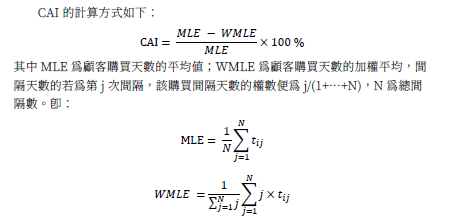

以下簡單舉個例子：

| Customer | t1  | t2  | t3  | MLE | WMLE                             | 解釋                                |
| :---:    | --- | --- | --- | --- | :---                             | :---:                               |
| 1        |  5  | 10  | 15  | 10  | (5\*1+10\*2+15\*3)/(1+2+3)=11.66 | 當間隔時間逐漸增長，WMLE>MLE，CAI<0   |
| 2        | 10  | 10  | 10  | 10  | (10\*1+10\*2+10\*3)/(1+2+3)=10   | 當間隔時間沒有變化，WMLE=MLE，CAI=0   |
| 3        | 15  | 10  | 5   | 10  | (15\*1+10\*2+5\*3)/(1+2+3)= 8.33 | 當間隔時間逐漸縮短，WMLE<MLE，CAI<0   |

### 計算購買期間

In [36]:
# 把交易時間排序 #
transactions_dates_by_id = transactions_cleaned.groupby('ID')['Date'].apply(lambda x: np.sort(x.unique()))

In [37]:
# 印出其中一個消費者的交易時間觀察資料型態 #
transactions_dates_by_id.loc[62]

array(['2006-01-05T00:00:00.000000000', '2006-02-24T00:00:00.000000000',
       '2006-04-05T00:00:00.000000000', '2006-11-25T00:00:00.000000000',
       '2006-12-10T00:00:00.000000000', '2007-01-06T00:00:00.000000000',
       '2007-02-11T00:00:00.000000000', '2007-02-24T00:00:00.000000000',
       '2007-03-24T00:00:00.000000000', '2007-05-30T00:00:00.000000000',
       '2007-06-09T00:00:00.000000000', '2007-06-12T00:00:00.000000000',
       '2007-07-08T00:00:00.000000000', '2007-12-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [38]:
# 計算間隔時間 #
diff_time = lambda x: [(x[i+1]-x[i]).astype('timedelta64[D]').astype(int) for i in range(len(x)) if i < len(x)-1]
interpurchase_time = transactions_dates_by_id.apply(diff_time)

In [39]:
# 間隔時間結果 #
interpurchase_time

ID
62      [50, 40, 234, 15, 27, 36, 13, 28, 67, 10, 3, 2...
87             [152, 161, 50, 13, 102, 2, 22, 14, 4, 124]
92                 [14, 92, 167, 49, 26, 227, 12, 22, 77]
139     [157, 5, 3, 111, 13, 25, 9, 6, 32, 109, 25, 14...
198     [15, 75, 63, 23, 8, 12, 13, 101, 87, 51, 13, 3...
                              ...                        
8006                                                   []
8059                                                   []
8141                                                  [1]
8192                                                   []
8202                                                   []
Name: Date, Length: 198, dtype: object

In [40]:
# 調整 index 與表頭 #
interpurchase_time = pd.DataFrame(interpurchase_time).reset_index(level=0)
interpurchase_time.columns = ['ID', 'InterpurchaseTime']

### 計算活躍度指標
* 接著計算顧客購買期間的平均(MLE)與加權平均(WMLE)
* $CAI=\frac{MLE-WMLE}{MLE}*100%$
* CAI 越大，顧客活躍度越高

In [41]:
# 計算 MLE #
interpurchase_time['AvgInterpurchase'] = interpurchase_time['InterpurchaseTime'].apply(np.mean)

C:\Users\Kevin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [42]:
# 計算 WMLE #

def weighted_average(x):
    x = np.array(x)
    w = np.array(range(len(x))) + 1
    if len(x) == 0:
        return np.nan
    else:
        return x.dot(w)/np.sum(w)

interpurchase_time['WeightedAvgInterpurchase'] = interpurchase_time['InterpurchaseTime'].apply(weighted_average)

In [43]:
# 計算 CAI #
MLE =  interpurchase_time['AvgInterpurchase']
WMLE = interpurchase_time['WeightedAvgInterpurchase'] 
interpurchase_time['CAI'] = (MLE - WMLE) / MLE

In [44]:
interpurchase_time

,ID,InterpurchaseTime,AvgInterpurchase,WeightedAvgInterpurchase,CAI
0,62,"[50, 40, 234, 15, 27, 36, 13, 28, 67, 10, 3, 2...",55.230769,52.780220,0.044369
1,87,"[152, 161, 50, 13, 102, 2, 22, 14, 4, 124]",64.400000,49.818182,0.226426
2,92,"[14, 92, 167, 49, 26, 227, 12, 22, 77]",76.222222,74.222222,0.026239
3,139,"[157, 5, 3, 111, 13, 25, 9, 6, 32, 109, 25, 14...",46.714286,44.361905,0.050357
4,198,"[15, 75, 63, 23, 8, 12, 13, 101, 87, 51, 13, 3...",34.277778,30.415205,0.112684
...,...,...,...,...,...
193,8006,[],NaN,NaN,NaN
194,8059,[],NaN,NaN,NaN
195,8141,[1],1.000000,1.000000,0.000000
196,8192,[],NaN,NaN,NaN


### 【分析】活躍度指標分析
* CAI 中位數 = 0
* 大部分的客戶 CAI 接近0，從動態的角度來看，整體屬於穩定狀態

In [45]:
# 檢視 CAI 的敘述統計 #
interpurchase_time.CAI.describe(percentiles=[0.2, 0.8])

count    172.000000
mean       0.032023
std        0.190127
min       -0.480663
20%       -0.128737
50%        0.000000
80%        0.202226
max        0.539526
Name: CAI, dtype: float64

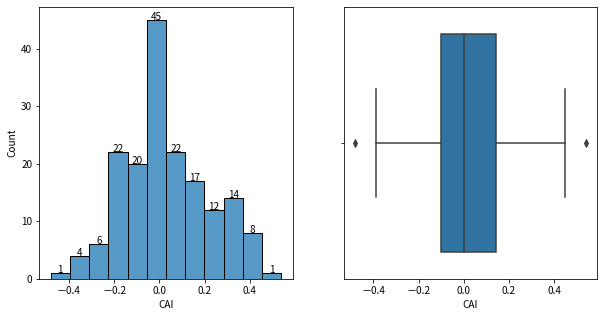

In [46]:
# 作圖觀察 CAI 分布 #
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ax=ax[0], x=interpurchase_time.CAI)
for p in ax[0].patches:
    ax[0].text(x=p.get_x()+0.5*p.get_width(), y=p.get_height(), s=p.get_height(), ha='center')
    
sns.boxplot(ax=ax[1], x=interpurchase_time.CAI)
plt.show()

### 【分析】ARFM 分析
* 橫軸為CAI = 0，縱軸為RFM各原始資料的中位數
* 第2象限：低價值高活躍度；第4象限：高價值低活躍度

**潛在問題**
1. 流失顧客群的數量大於成長顧客數
 * R維度：成長顧客數 28人 < 流失顧客數 49人
 * F維度：成長顧客數 24人 < 流失顧客數42人
 * M維度：成長顧客數 41人 < 流失顧客數62人
    * 固然有新客戶(第2象限)加入，但是舊有顧客的流失(第4象限)是一項隱憂
    * 留住顧客的能力差，會造成公司行銷成本過大(因開發新客戶的費用遠大於留住舊客戶的成本)
2. 中間穩定的顧客價值不佳：R最長、F最少、M的平均也最小
    * 在目前的經營模式下，活躍顧客成為穩定客戶之後，顧客價值成長有限，甚至可能出現衰退情形

In [47]:
# 加入顧客活躍度與高價值欄位 #
rfm_data = rfm_data.merge(interpurchase_time[['ID', 'CAI']], left_on='客戶ID', right_on='ID')
rfm_data = rfm_data.drop('ID',axis=1)

r_med = np.median(rfm_data.Reccency)
f_med = np.median(rfm_data.Frequency)
m_med = np.median(rfm_data.MonetaryValue)

rfm_data['Active'] = rfm_data.CAI > 0
rfm_data['LowReccency'] = -rfm_data.Reccency > -r_med
rfm_data['HighFrequency'] = rfm_data.Frequency > f_med
rfm_data['HighMonetaryValue'] = rfm_data.MonetaryValue > m_med

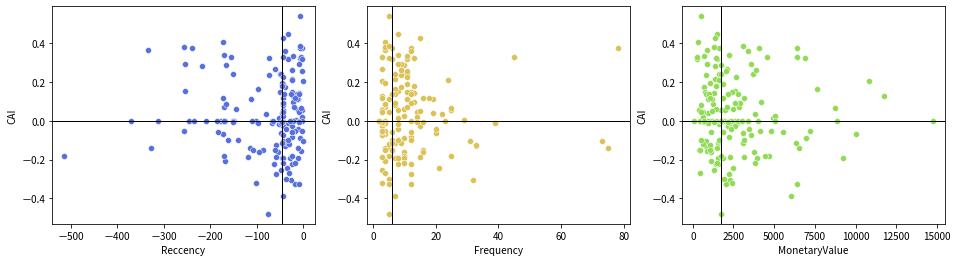

In [48]:
# 繪製 ARFM 散布圖 #
fig, ax = plt.subplots(1,3, figsize=(16,4))
sns.scatterplot(x=-rfm_data.Reccency, y=rfm_data.CAI, data=rfm_data, ax=ax[0], color=sns.color_palette("hls", 8)[5])
ax[0].axhline(y=0, linestyle='-', linewidth=1, color='black')
ax[0].axvline(x=-np.median(rfm_data.Reccency), linewidth=1, color='black')

sns.scatterplot(x='Frequency', y='CAI', data=rfm_data, ax=ax[1], color=sns.color_palette("hls", 8)[1])
ax[1].axhline(y=0, linestyle='-', linewidth=1, color='black')
ax[1].axvline(x=np.median(rfm_data.Frequency), linewidth=1, color='black')

sns.scatterplot(x='MonetaryValue', y='CAI', data=rfm_data, ax=ax[2], color=sns.color_palette("hls", 8)[2])
ax[2].axhline(y=0, linestyle='-', linewidth=1, color='black')
ax[2].axvline(x=np.median(rfm_data.MonetaryValue), linewidth=1, color='black')

plt.show()

In [49]:
# 印出各維度數字 #
print(rfm_data.groupby(['Active', 'LowReccency'])['客戶ID'].count())
print("\n")

print(rfm_data.groupby(['Active', 'HighFrequency'])['客戶ID'].count())
print("\n")

print(rfm_data.groupby(['Active', 'HighMonetaryValue'])['客戶ID'].count())
print("\n")

Active  LowReccency
False   False          71
        True           49
True    False          28
        True           50
Name: 客戶ID, dtype: int64


Active  HighFrequency
False   False            78
        True             42
True    False            24
        True             54
Name: 客戶ID, dtype: int64


Active  HighMonetaryValue
False   False                58
        True                 62
True    False                41
        True                 37
Name: 客戶ID, dtype: int64




In [50]:
# 依 CAI前20%、中間60%、後20%分成「漸活躍」、「穩定」、「漸靜止」三個群體 #
def get_activeness_category(x):
    prec = np.percentile(rfm_data.CAI.dropna(), [20, 80])
    if x == np.nan:
        return np.nan
    if x < prec[0]:
        return 'Bottom 20%'
    elif x > prec[1]:
        return 'Top 20%'
    else:
        return 'Stable'
    
rfm_data['ActivenessCategory'] = rfm_data['CAI'].apply(get_activeness_category)

In [51]:
# 印出三個群體的 RFM 敘述統計 #
pd.set_option("precision", 2)
rfm_data.groupby('ActivenessCategory')[['Reccency', 'Frequency', 'MonetaryValue']].describe(percentiles=[0.5])

Reccency                                 Frequency         \
                      count   mean    std  min   50%    max     count   mean   
ActivenessCategory                                                             
Bottom 20%             35.0  77.29  97.88  4.0  46.0  514.0      35.0  11.97   
Stable                128.0  87.88  82.38  1.0  46.0  371.0     128.0   7.77   
Top 20%                35.0  79.94  91.72  1.0  43.0  333.0      35.0  11.40   

                                          MonetaryValue                    \
                      std  min  50%   max         count     mean      std   
ActivenessCategory                                                          
Bottom 20%          13.32  3.0  8.0  75.0          35.0  2542.51  2021.15   
Stable               9.54  1.0  4.0  73.0         128.0  2358.74  2362.73   
Top 20%             13.79  3.0  9.0  78.0          35.0  2533.59  2262.42   

                                               
                       min      50%       max  
ActivenessCategory                             
Bottom 20%          398.00  1870.71   9241.60  
Stable               87.00  1704.12  14754.50  
Top 20%             270.83  1628.17  10812.33

### 【分析】流失客戶分析
* 從Reccency、Frequency 和 Monetary Value 的角度去看，找出的流失客戶大抵是同一批人(由下方ID對照圖觀察)
* 未來的行銷策略要解決這個問題
    * 進一步行銷研究
    * 設計具有吸引力的優惠組合

In [52]:
# 找出不活躍高價值客戶的顧客ID #
r_inactive_valuable = pd.DataFrame(rfm_data[(rfm_data.CAI<0) & (rfm_data.LowReccency==True)]['客戶ID'])
r_inactive_valuable['Inactive'] = 'R'

f_inactive_valuable = pd.DataFrame(rfm_data[(rfm_data.CAI<0) & (rfm_data.HighFrequency==True)]['客戶ID'])
f_inactive_valuable['Inactive'] = 'F'

m_inactive_valuable = pd.DataFrame(rfm_data[(rfm_data.CAI<0) & (rfm_data.HighMonetaryValue==True)]['客戶ID'])
m_inactive_valuable['Inactive'] = 'M'

inactive_valuable_customers = pd.concat([r_inactive_valuable, f_inactive_valuable, m_inactive_valuable], axis=0)

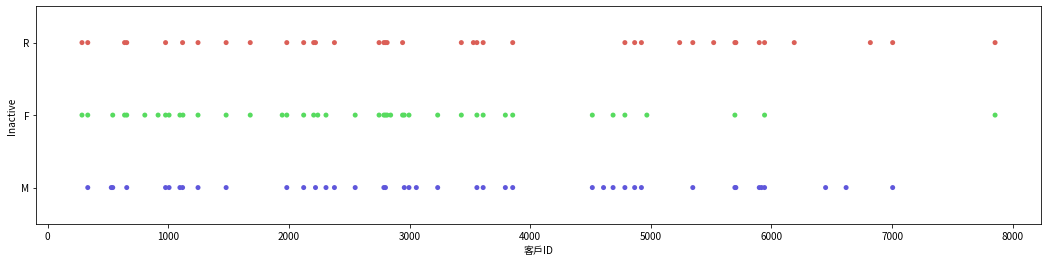

In [53]:
# 把 RFM 中不活躍高價值客戶印出來，大概是同一批人 #
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(111)
sns.stripplot(x="客戶ID", y="Inactive", jitter=False, data=inactive_valuable_customers, ax=ax, palette=sns.color_palette("hls", 3))
plt.show()

In [54]:
# 印出來看一下是哪些人 #
np.sort(inactive_valuable_customers['客戶ID'].unique())

array([ 284,  332,  527,  539,  637,  655,  805,  915,  977, 1006, 1096,
       1118, 1121, 1246, 1479, 1679, 1944, 1982, 2122, 2205, 2220, 2239,
       2307, 2377, 2549, 2747, 2787, 2800, 2814, 2843, 2942, 2956, 2995,
       3056, 3233, 3429, 3529, 3558, 3610, 3794, 3855, 4515, 4608, 4687,
       4785, 4866, 4922, 4967, 5239, 5348, 5521, 5697, 5705, 5899, 5918,
       5943, 6189, 6449, 6619, 6820, 7005, 7854], dtype=int64)

## 儲存處理後資料
包含:
* `_rfm_data.csv`
* `_interpurchase_time.csv`

(前綴`_`代表修改後資料)

In [55]:
rfm_data.to_csv("_rfm_data.csv")
rfm_data

,客戶ID,Gender,Age,Zipcode,Area,FirstPurchase,NPurchase,Reccency,Frequency,MonetaryValue,TotalAmount,CAI,Active,LowReccency,HighFrequency,HighMonetaryValue,ActivenessCategory
0,3596,男,37,247,北區,2006-03-21,28,7,13,6922.08,89987,0.32,True,True,True,True,Top 20%
1,1729,女,29,112,北區,2006-04-19,4,155,3,6416.67,19250,0.33,True,False,False,True,Top 20%
2,2036,男,30,237,北區,2006-07-29,4,327,4,1082.25,4329,-0.14,False,False,False,False,Bottom 20%
3,1686,男,34,234,北區,2006-01-26,172,3,78,6419.87,494330,0.38,True,True,True,True,Top 20%
4,5943,女,48,802,南區,2006-12-24,12,43,7,6005.71,42040,-0.39,False,True,True,True,Bottom 20%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,6966,男,52,110,北區,2007-06-08,4,207,1,3500.00,3500,NaN,False,False,False,True,Stable
194,6997,男,38,600,南區,2007-06-14,5,110,2,5045.00,10090,0.00,False,False,False,True,Stable
195,3292,女,39,220,北區,2006-07-16,16,254,8,3590.00,28720,0.29,True,False,True,True,Top 20%
196,4922,男,44,526,中區,2006-07-14,11,10,5,6425.20,32126,-0.33,False,True,False,True,Bottom 20%


In [56]:
interpurchase_time.to_csv("_interpurchase_time.csv")
interpurchase_time

,ID,InterpurchaseTime,AvgInterpurchase,WeightedAvgInterpurchase,CAI
0,62,"[50, 40, 234, 15, 27, 36, 13, 28, 67, 10, 3, 2...",55.23,52.78,0.04
1,87,"[152, 161, 50, 13, 102, 2, 22, 14, 4, 124]",64.40,49.82,0.23
2,92,"[14, 92, 167, 49, 26, 227, 12, 22, 77]",76.22,74.22,0.03
3,139,"[157, 5, 3, 111, 13, 25, 9, 6, 32, 109, 25, 14...",46.71,44.36,0.05
4,198,"[15, 75, 63, 23, 8, 12, 13, 101, 87, 51, 13, 3...",34.28,30.42,0.11
...,...,...,...,...,...
193,8006,[],NaN,NaN,NaN
194,8059,[],NaN,NaN,NaN
195,8141,[1],1.00,1.00,0.00
196,8192,[],NaN,NaN,NaN
